# 1. Introduction
I was reminiscing Rihanna's old songs, and then decided to do an EDA on [Rihanna Lyrics dataset](https://www.kaggle.com/vivovinco/rihanna-lyrics).<br>
Hope you enjoy this one.

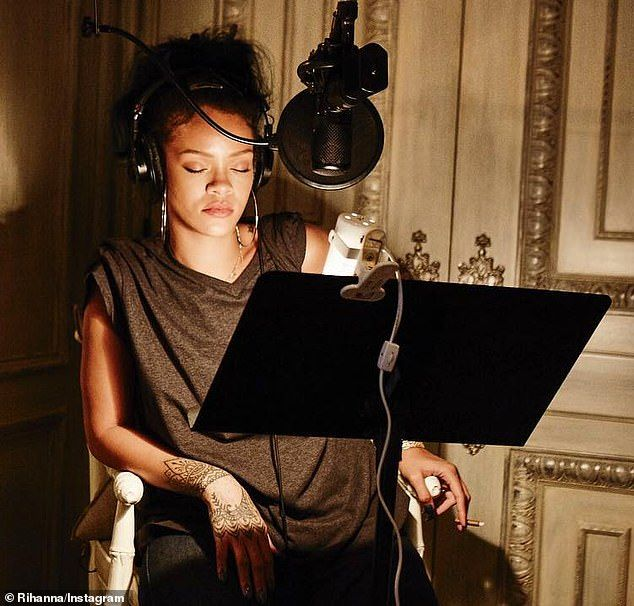

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud,STOPWORDS
import spacy as sp
import string
import nltk
import re
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download("vader_lexicon")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nlps = sp.load('en')
from nltk.util import ngrams

plt.rc("figure",figsize=(18,11))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [2]:
rih = pd.read_csv("../input/rihanna-lyrics/Rihanna Lyrics.csv", delimiter=";", encoding="Windows-1252")
rih

album                            song  \
0    Music of the Sun                   Pon de Replay   
1    Music of the Sun                 Here I Go Again   
2    Music of the Sun    If It’s Lovin’ That You Want   
3    Music of the Sun  You Don’t Love Me (No, No, No)   
4    Music of the Sun                 That La, La, La   
..                ...                             ...   
108              ANTI                          Higher   
109              ANTI                    Close to You   
110              ANTI                Goodnight Gotham   
111              ANTI                            Pose   
112              ANTI                     Sex with Me   

                                                lyrics  year    views  
0    [Chorus]\nCome, Mr. DJ, song pon de replay\nCo...  2005   127800  
1    [Intro: Rihanna]\nNa-na-na-na-na\nNa-na-na-na-...  2005     6000  
2    [Intro]\nI wanna let you know\nThat you don't ...  2005    27100  
3    [Intro: Vybz Kartel]\nVybz Kartel\nRihanna\nYo...  2005     7300  
4    [Intro]\nHere we go\n(Oh) la, la, la, la, la, ...  2005        0  
..                                                 ...   ...      ...  
108  [Verse]\nThis whiskey got me feelin' pretty\nS...  2016   568600  
109  [Verse 1]\nNothing but a tear, that's all for ...  2016   504400  
110  Only if for a night\n\nNight, night, for a nig...  2016   140900  
111  [Intro]\nOh yeah, yeah, yeah\nYeah, yeah, yeah...  2016   245100  
112  [Chorus]\nSex with me, so amazing\nAll this al...  2016  1100000  

[113 rows x 5 columns]

# 2. Data Preprocessing and Feature Engineering


In [3]:
preprocessed = rih.copy()
for col in preprocessed.columns[:-2]:
    preprocessed[col] = preprocessed[col].str.lower()

def extract_feat(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find("ft.") != -1:
        return artist.replace("ft. ","")
    else:
        return "solo"
    
def remove_artist(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find("ft.") != -1:
        return s[:s.find("(")]
    else:
        return s
    
preprocessed["featuring"] = preprocessed.song.apply(extract_feat)
preprocessed.song = preprocessed.song.apply(remove_artist)
preprocessed.song = preprocessed.song.apply(lambda x:re.sub(r"[^\w\s]", "", x) )


preprocessed = preprocessed.loc[preprocessed.lyrics.dropna().index,:]

preprocessed["number_of_verses"]=0
preprocessed["number_of_chorus"]=0
preprocessed.loc[preprocessed.lyrics.notna().index,"number_of_verses"] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r"verse",x)))
preprocessed.loc[preprocessed.lyrics.notna().index,"number_of_chorus"] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r"chorus",x)))

preprocessed.loc[preprocessed.lyrics.notna().index,"lyrics"] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: re.sub(r"\[([^]]*)]","",x))
preprocessed.loc[preprocessed.lyrics.notna().index,"lyrics"] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: x.replace("\n"," "))
preprocessed.loc[preprocessed.lyrics.notna().index,"lyrics"] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:re.sub(r"[^\w\s]","", x))


sid = SIA()
preprocessed["sentiments"]           = preprocessed["lyrics"].apply(lambda x: sid.polarity_scores(x))
preprocessed["Positive Sentiment"]   = preprocessed["sentiments"].apply(lambda x: x["pos"]) 
preprocessed["Neutral Sentiment"]    = preprocessed["sentiments"].apply(lambda x: x["neu"])
preprocessed["Negative Sentiment"]   = preprocessed["sentiments"].apply(lambda x: x["neg"])

preprocessed.drop(columns=['sentiments'],inplace=True)

preprocessed["# Of Words"]                 = preprocessed["lyrics"].apply(lambda x: len(x.split(" ")))
preprocessed["# Of StopWords"]             = preprocessed["lyrics"].apply(lambda x: len([word for word in x.split(" ") if word in list(STOPWORDS)]))
preprocessed["Average Word Length"]        = preprocessed["lyrics"].apply(lambda x: np.mean(np.array([len(va) for va in x.split(" ") if va not in list(STOPWORDS)])))
preprocessed["Average Sentence Length"]    = preprocessed["lyrics"].apply(lambda x: np.mean(np.array([len(va) for va in x.split(".")])))

#Album Mean Statistics DF
album_rih = preprocessed.groupby(by='album').mean()

preprocessed

album                        song  \
0    music of the sun               pon de replay   
1    music of the sun             here i go again   
2    music of the sun  if its lovin that you want   
3    music of the sun   you dont love me no no no   
4    music of the sun               that la la la   
..                ...                         ...   
108              anti                      higher   
109              anti                close to you   
110              anti            goodnight gotham   
111              anti                        pose   
112              anti                 sex with me   

                                                lyrics  year    views  \
0     come mr dj song pon de replay come mr dj wont...  2005   127800   
1     nanananana nanananana nananananananananananan...  2005     6000   
2     i wanna let you know that you dont have to go...  2005    27100   
3     vybz kartel rihanna you know my love for yous...  2005     7300   
4     here we go oh la la la la la yeah oh la la la...  2005        0   
..                                                 ...   ...      ...   
108   this whiskey got me feelin pretty so pardon i...  2016   568600   
109   nothing but a tear thats all for breakfast wa...  2016   504400   
110  only if for a night  night night for a night f...  2016   140900   
111   oh yeah yeah yeah yeah yeah yeah oh yeah yeah...  2016   245100   
112   sex with me so amazing all this all hard work...  2016  1100000   

    featuring  number_of_verses  number_of_chorus  Positive Sentiment  \
0        solo                 2                 8               0.060   
1        solo                 3                 6               0.111   
2        solo                 2                 7               0.149   
3        solo                 3                 3               0.240   
4        solo                 2                 5               0.263   
..        ...               ...               ...                 ...   
108      solo                 1                 1               0.126   
109      solo                 2                 4               0.233   
110      solo                 0                 0               0.000   
111      solo                 3                 3               0.302   
112      solo                 2                 3               0.229   

     Neutral Sentiment  Negative Sentiment  # Of Words  # Of StopWords  \
0                0.932               0.008         688             251   
1                0.792               0.097         460             224   
2                0.814               0.038         545             283   
3                0.558               0.202         499             233   
4                0.730               0.007         727             252   
..                 ...                 ...         ...             ...   
108              0.782               0.092         123              58   
109              0.672               0.095         180              86   
110              1.000               0.000         442             206   
111              0.527               0.171         208              82   
112              0.669               0.102         305             146   

     Average Word Length  Average Sentence Length  
0               3.764302                   3038.0  
1               4.593220                   2221.0  
2               4.427481                   2532.0  
3               3.853383                   2081.0  
4               3.309474                   2937.0  
..                   ...                      ...  
108             4.292308                    556.0  
109             4.531915                    832.0  
110             4.161017                   1841.0  
111             3.992063                    911.0  
112             4.440252                   1395.0  

[113 rows x 15 columns]

# 3. Exploratory Data Analysis
First, check for missing values and handle them if there is any.<br>
Then, visualize the data.

In [4]:
# get the number of missing data points per column
missing_values_count = rih.isnull().sum()

# look at the number of missing points in the column
missing_values_count[:]

album     0
song      0
lyrics    0
year      0
views     0
dtype: int64

## 3.1. Label Based Analysis


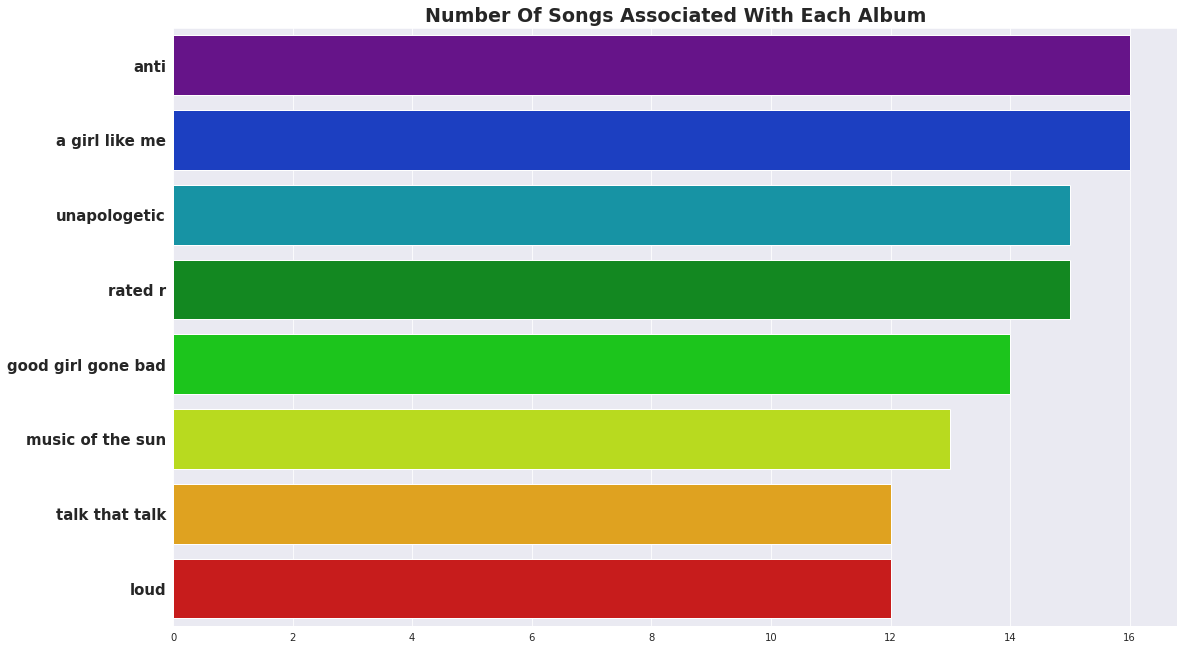

In [5]:
plt.title("Number Of Songs Associated With Each Album",fontsize=19,fontweight="bold")
ax = sns.barplot(y=preprocessed.album.value_counts().index,x=preprocessed.album.value_counts().values,palette="nipy_spectral")
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15,fontweight="bold")
plt.show()

Rihanna has an average of 14 songs per album which is great!

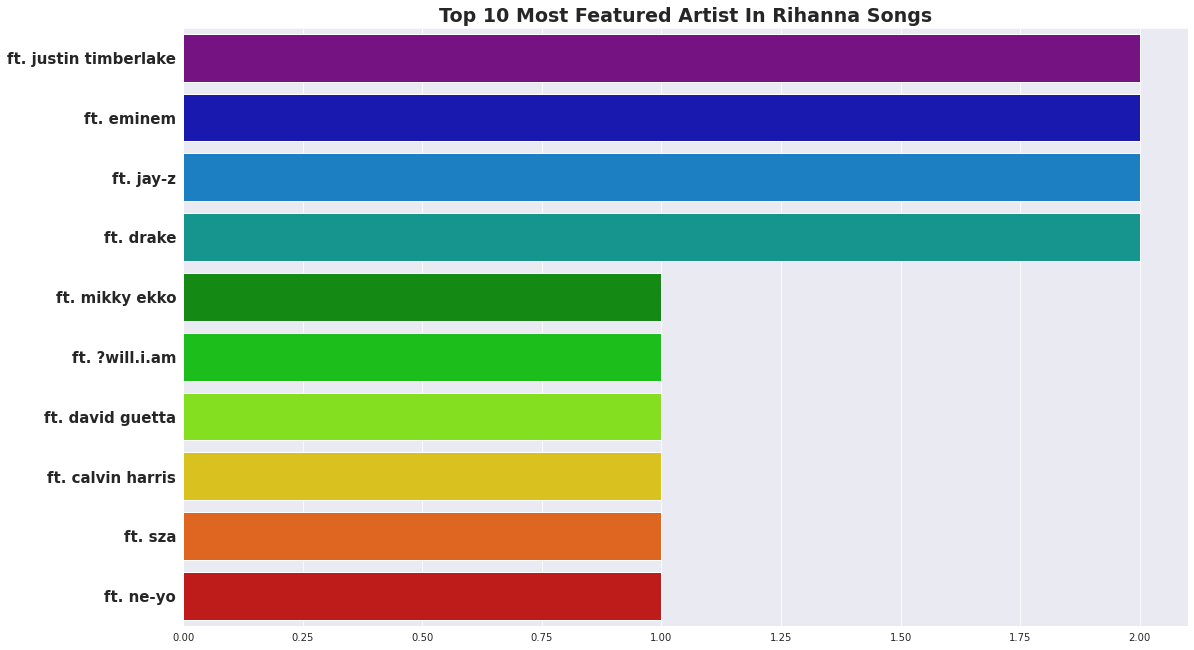

In [6]:
plt.title('Top 10 Most Featured Artist In Rihanna Songs',fontsize=19,fontweight='bold')
ax = sns.barplot(y=preprocessed.featuring.value_counts()[1:11].index,x=preprocessed.featuring.value_counts()[1:11].values,palette='nipy_spectral')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15,fontweight='bold')
plt.show()

## 3.2. Correlation Analysis


In [7]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))

s_val =preprocessed.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1),
    row=1, col=1)

s_val =preprocessed.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1),
    row=2, col=1)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"))

fig.update_layout(height=700, width=900, title_text="Correlations Between Our Different Numeric Features")
fig.show()

In [8]:
fig = go.Figure()
album_rih = album_rih.sort_values(by='year')
album_rihanna = album_rih.groupby(by='year').mean().reset_index()

for column in album_rihanna.columns[:-1]:
    fig.add_trace(
        go.Scatter(
            x = album_rihanna.year,
            y = album_rihanna[column],
            name = column,))


btns = []
for x,col in enumerate(album_rihanna.columns[:-1]):
    bol = [False]*12
    bol[x]=True
    d = dict(label = col,
                  method = 'update',
                  args = [{'visible':bol},
                          {'title': 'Distribution of [' +col+'] Over The Years',
                           'showlegend':True}])
    btns.append(d)
    
    
fig.update_layout(title='Features Distribution Over The Years',
    updatemenus=[go.layout.Updatemenu(
        active=0,
        showactive=True,
        buttons=btns)])


fig.show()

## 3.3. Album Based Analysis


In [9]:
album_mean = album_rih.sort_values(by="year")

album_year_index =[album + "  "+ str(year) for album,year in zip(album_mean.index,album_mean.year)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Positive Sentiment'],
                    mode='lines+markers',
                    name='Mean Positive Sentiment Value',hovertext=album_mean['year']))
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Negative Sentiment'],
                    mode='lines+markers',
                    name='Mean Negative Sentiment Value',hovertext=album_mean['year']))

fig.update_layout(title='Album Sentiment Change Over The Years')
fig.show()
#album_mean

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['number_of_verses'],
                    mode='lines+markers',
                    name='Mean Verse Amount',hovertext=album_mean['year']))
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['number_of_chorus'],
                    mode='lines+markers',
                    name='Mean Chorus Amount',hovertext=album_mean['year']))

fig.update_layout(title='Album Chorus and Verse Count Change Over The Years')
fig.show()

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['views'],
                    mode='lines+markers',
                    name='Mean Verse Amount',hovertext=album_mean['year']))

fig.update_layout(title='Album Views Over The Years')
fig.show()

The most viewed two albums of Rih's ([Unapologetic](https://en.wikipedia.org/wiki/Unapologetic) and [ANTI](https://en.wikipedia.org/wiki/Anti_(album))) has the lowest mean values of choruses.<br>
Besides, I haven't noticed that she released an album almost every year until ANTI. 😐

## 3.4. Text Based Analysis


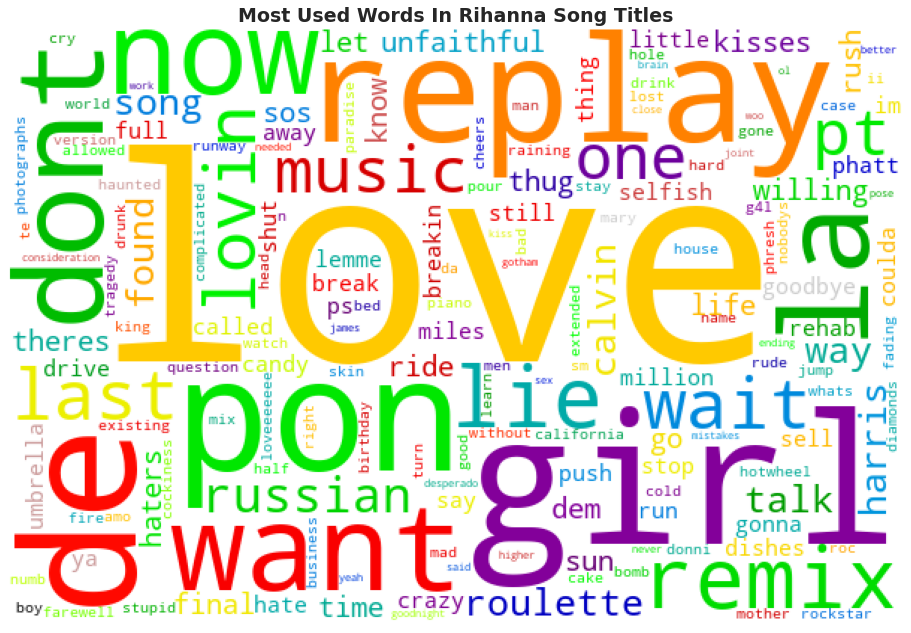

In [12]:
l_t = ' '.join(preprocessed.song).strip().replace('rihanna','')
l_t = l_t.replace('ft','')
w_c = WordCloud(width=600,height=400,collocations = False,stopwords=STOPWORDS,colormap='nipy_spectral',background_color='white').generate(l_t)

plt.title('Most Used Words In Rihanna Song Titles',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

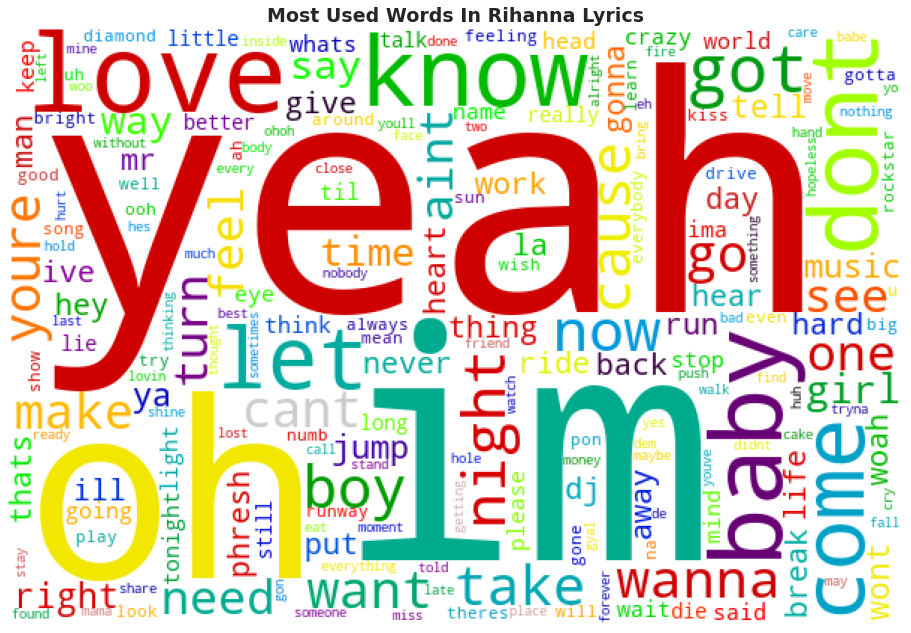

In [13]:
l_t = ' '.join(preprocessed.lyrics[preprocessed.lyrics.notna()]).strip()
w_c = WordCloud(width=600,height=400,collocations = False,stopwords=STOPWORDS,colormap='nipy_spectral',background_color='white').generate(l_t)

plt.title('Most Used Words In Rihanna Lyrics',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

In [14]:
#preprocessed.lyrics
w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

w2_dict = dict()

top_10_w1 = list(w1_dict.keys())[:10]
token=nltk.word_tokenize(l_t)
trigram =ngrams(token,3)
trigram = [k for k in trigram if k[0] in top_10_w1]

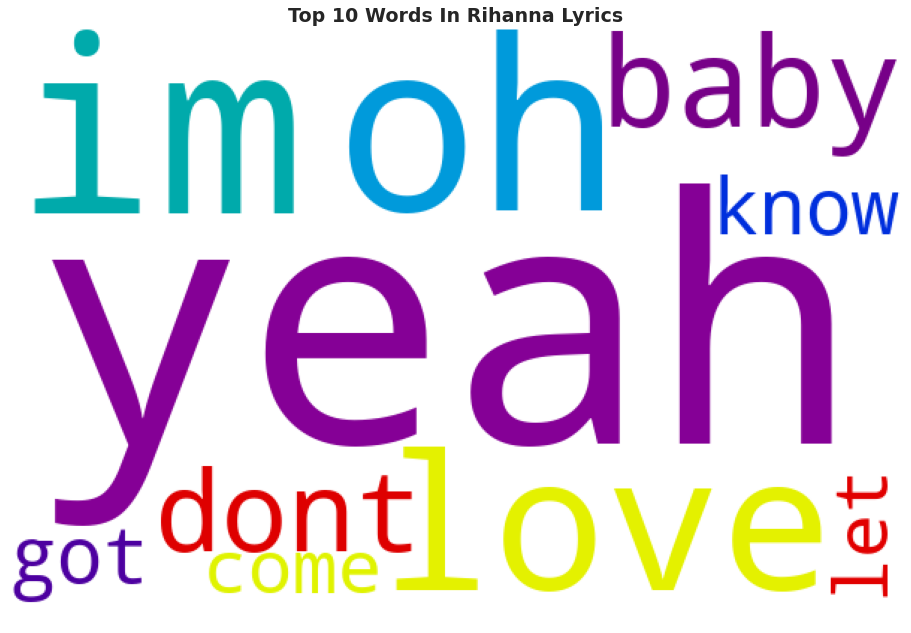

In [15]:
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_w1))
plt.title('Top 10 Words In Rihanna Lyrics',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

# 4. Vectorization And Decomposition


In [16]:
NUMBER_OF_COMPONENTS=100

CV = CountVectorizer()
svd = TruncatedSVD(NUMBER_OF_COMPONENTS)

c_matrix = CV.fit_transform(preprocessed.lyrics)

dec_matrix = svd.fit_transform(c_matrix)
dec_df=pd.DataFrame(dec_matrix,columns=['PC_{}'.format(i) for i in range(1,NUMBER_OF_COMPONENTS+1)])

ex_var = svd.explained_variance_ratio_
variance_cum = np.cumsum(ex_var)
data = [go.Scatter(x=np.arange(0,len(variance_cum)),y=variance_cum,name='Cumulative Explained Variance',mode='lines+markers'),
        go.Scatter(x=np.arange(0,len(variance_cum)),y=ex_var,name='Explained Variance',mode='lines+markers')]
layout = dict(title='Explained Variance Ratio Using {} Words'.format(NUMBER_OF_COMPONENTS),
             xaxis_title='# Componenets',yaxis_title='Explained Variance',height=650,width=900)
fig = go.Figure(data=data,layout=layout)
fig.update_layout(template='seaborn')
fig.show()

Apparently, more than 90% of the variance in Rihanna's lyrics can be explained using only 100 words.